In [101]:
#Import required libraries

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import progressbar

from datetime import datetime
from scipy import signal
from pydicom import dcmread
from pydicom.waveforms import multiplex_array

#Set options
np.set_printoptions(threshold = 500)

%matplotlib inline

In [117]:
# Define class for reading ECGs from DICOM files.

class ECGDICOMReader:
    """ Extract voltage data from a ECG DICOM file
        Author: Philip Croon, p.croon@amsterdamumc.nl
        for questions feel free to email.    
        
        --Update 2023-09-19  Added information on Manufacturer, Accession number, Software and the Median Waveforms by Stephan van der Zwaard
    """

    def __init__(self, augmentLeads=False, resample_500=True):
        """ 
        Initialize class. If resample_500 is True ECGs with sampling frequency that are not 500 will be resampled to 500. 
        If AugmentLeads = True and the augmented leads are not available, they are calculated. 
        """
        self.augmentLeads = augmentLeads
        self.resample_500 = resample_500
        print("Initialization succesfull")

    def __call__(self, path, verbose=False):
        
        try:
            with open(path, 'rb') as DICOM:
                
                # Open DICOM file
                self.ECG                   = dcmread(DICOM)
                
                # Add DICOM information by relevant tags
                # General information
                
                # Check if key DICOM tags are present
                if set(['SOPInstanceUID','SeriesInstanceUID','StudyInstanceUID','PatientID','AccessionNumber','StudyDate','StudyTime']).issubset(self.ECG.dir()) == True:
                    self.SOPinstanceUID        = self.ECG.SOPInstanceUID
                    self.SERIESinstanceUID     = self.ECG.SeriesInstanceUID
                    self.STUDYinstanceUID      = self.ECG.StudyInstanceUID
                    self.PatientID             = self.ECG.PatientID
                    self.StudyDate             = self.ECG.StudyDate
                    self.StudyTime             = self.ECG.StudyTime
                    self.AccessionNumber       = self.ECG.AccessionNumber
                else:
                    if (verbose==True): 
                        print('Essential DICOM tags are missing: inspect DICOM file')
                    return(pd.DataFrame({'filetype': [self.ECG.data_element('SOPClassUID').repval], 'error': 'Essential DICOM tags missing'}) )
                    
                # Fill general info with other DICOM tags (if present)                
                self.PatientBirthDate      = self.ECG.PatientBirthDate      if set(['PatientBirthDate']).issubset(self.ECG.dir()) else ''
                self.PatientName           = self.ECG.PatientName           if set(['PatientName']).issubset(self.ECG.dir()) else ''
                self.PatientSex            = self.ECG.PatientSex            if set(['PatientSex']).issubset(self.ECG.dir()) else ''
                self.StudyDescription      = self.ECG.StudyDescription      if set(['StudyDescription']).issubset(self.ECG.dir()) else ''
                self.AcquisitionDateTime   = self.ECG.AcquisitionDateTime   if set(['AcquisitionDateTime']).issubset(self.ECG.dir()) else ''
                self.AcquisitionTimeZone   = self.ECG.TimezoneOffsetFromUTC if set(['TimezoneOffsetFromUTC']).issubset(self.ECG.dir()) else ''
                self.Manufacturer          = self.ECG.Manufacturer          if set(['Manufacturer']).issubset(self.ECG.dir()) else ''
                self.ManufacturerModelName = self.ECG.ManufacturerModelName if set(['ManufacturerModelName']).issubset(self.ECG.dir()) else ''
                self.SoftwareVersions      = self.ECG.SoftwareVersions      if set(['SoftwareVersions']).issubset(self.ECG.dir()) else ''
                self.DataExportedBy        = self.ECG.IssuerOfPatientID     if set(['IssuerOfPatientID']).issubset(self.ECG.dir()) else ''

                
                # Waveform information
                # Check existance of raw Waveform
                try:
                    self.Waveforms             = self.ECG.waveform_array(0).T
                except:
                    if (verbose==True): 
                        print('No ECG waveform present: inspect DICOM file')
                    return(pd.DataFrame({'filetype': [self.ECG.data_element('SOPClassUID').repval], 'error': 'No ECG waveform present'}) )
                
                # Add channel settings and lead information 
                settings                   = self.ECG.WaveformSequence[0].ChannelDefinitionSequence[0]
                self.ChannelSensitivity    = settings.ChannelSensitivity   if set(['ChannelSensitivity']).issubset(settings.dir()) else '' 
                self.ChannelBaseline       = settings.ChannelBaseline      if set(['ChannelBaseline']).issubset(settings.dir()) else '' 
                self.ChannelSampleSkew     = settings.ChannelSampleSkew    if set(['ChannelSampleSkew']).issubset(settings.dir()) else '' 
                self.FilterLowFrequency    = settings.FilterLowFrequency   if set(['FilterLowFrequency']).issubset(settings.dir()) else '' 
                self.FilterHighFrequency   = settings.FilterHighFrequency  if set(['FilterHighFrequency']).issubset(settings.dir()) else '' 
                self.NotchFilterFrequency  = settings.NotchFilterFrequency if set(['NotchFilterFrequency']).issubset(settings.dir()) else ''        
                self.lead_info_final       = self.lead_info(0)
                self.LeadVoltages          = self.make_leadvoltages(0)
                self.sf                    = self.ECG.WaveformSequence[0].SamplingFrequency

                # Check existance of MedianWaveform
                try: 
                    self.MedianWaveforms       = self.ECG.waveform_array(1).T
                    self.lead_info_final       = self.lead_info(1)
                    self.LeadVoltages2         = self.make_leadvoltages(1)
                    self.MedianWaveformPresent = 'Yes'
                except: 
                    self.MedianWaveformPresent = 'No'
                    self.MedianWaveforms       = ''
                    self.LeadVoltages2         = np.zeros((0,0))
                    if (verbose==True): 
                        print('No Median Waveform present')

                self.samplingfrequency     = self.resampling_500hz()

                # Create dictionary from the above 
                self.read_dict_final       = self.readable_dict()
            
            return self.read_dict_final

        except Exception as e:
            print(str(e))
            pass

    def readable_dict(self):
        """Make a readable dict"""
        read_dict                             = {}
        read_dict["SOPinstanceUID"]           = self.SOPinstanceUID
        read_dict["SERIESinstanceUID"]        = self.SERIESinstanceUID
        read_dict["STUDYinstanceUID"]         = self.STUDYinstanceUID
        read_dict["PatientID"]                = self.PatientID
        read_dict["PatientBirthDate"]         = self.PatientBirthDate
        read_dict["PatientName"]              = str(self.PatientName)
        read_dict["PatientSex"]               = self.PatientSex
        read_dict["StudyDate"]                = datetime.strptime(self.StudyDate, "%Y%m%d").strftime('%Y-%m-%d') #if your date is different format adapt
        read_dict["StudyTime"]                = self.StudyTime
        read_dict["StudyDescription"]         = self.StudyDescription
        read_dict["AcquisitionDateTime"]      = self.AcquisitionDateTime
        read_dict["AcquisitionTimeZone"]      = self.AcquisitionTimeZone
        #read_dict["DatapointsWaveform"]       = len(list(self.LeadVoltages.values())[0])
        #read_dict["DatapointsMedianWaveform"] = len(list(self.LeadVoltages2.values())[0])
        read_dict["AccessionNumber"]          = self.AccessionNumber
        read_dict["SamplingFrequency"]        = self.samplingfrequency
        read_dict["ChannelSensitivity"]       = self.ChannelSensitivity
        read_dict["ChannelBaseline"]          = self.ChannelBaseline
        read_dict["ChannelSampleSkew"]        = self.ChannelSampleSkew
        read_dict["FilterLowFrequency"]       = self.FilterLowFrequency
        read_dict["FilterHighFrequency"]      = self.FilterHighFrequency
        read_dict["NotchFilterFrequency"]     = self.NotchFilterFrequency
        read_dict["Manufacturer"]             = self.Manufacturer
        read_dict["ManufacturerModelName"]    = self.ManufacturerModelName
        read_dict["SoftwareVersions"]         = self.SoftwareVersions
        read_dict["DataExportedBy"]           = self.DataExportedBy
        read_dict["Waveforms"]                = self.LeadVoltages
        read_dict["MedianWaveforms"]          = self.LeadVoltages2
        return read_dict

    def make_leadvoltages(self,nr):
        """Extracts the voltages out of the DICOM"""
        num_leads = 0
        leads = {}

        for i, lead in enumerate(self.ECG.waveform_array(nr).T):
            num_leads += 1
            leads[self.lead_info_final[i]] = lead
        if num_leads == 8 and self.augmentLeads:
            leads['III'] = np.subtract(leads['II'], leads['I'])
            leads['aVR'] = np.add(leads['I'], leads['II']) * (-0.5)
            leads['aVL'] = np.subtract(leads['I'], 0.5 * leads['II'])
            leads['aVF'] = np.subtract(leads['II'], 0.5 * leads['I'])
        return leads

    def lead_info(self,nr):
        """returns the names of the channels from the DICOM"""
        leadnames = {}
        for ii, channel in enumerate(self.ECG.WaveformSequence[nr].ChannelDefinitionSequence):
            source = channel.ChannelSourceSequence[0].CodeMeaning
            units = "unitless"
            if "ChannelSensitivity" in channel:
                units = channel.ChannelSourceSequence[0].CodeMeaning
            leadnames[ii] = source.replace('Lead','').strip()
        return leadnames

    def resampling_500hz(self):
        """In case sf is 250, make 500"""
        if self.resample_500 is False:
            return int(self.sf)
        else:
            if int(self.sf) != 500:
                for i in self.LeadVoltages:
                    self.LeadVoltages[f"{i}"] = signal.resample(self.LeadVoltages[f"{i}"], 5000)
                    self.oversampled = "Yes"
                if self.MedianWaveformPresent == 'Yes':
                    for i in self.LeadVoltages:
                        self.LeadVoltages2[f"{i}"] = signal.resample(self.LeadVoltages2[f"{i}"], 600)
                self.sf = 500
                return self.sf
            else:
                return self.sf
        return self

In [118]:
#Initialize
ecgreader = ECGDICOMReader()

Initialization succesfull


In [3]:
# Define path
path_to_dicom = "C:/Users/Stephan.vanderZwaard/Documents/dicom/ECG-DICOM/"

# Obtain all DICOM files
files = os.listdir(path_to_dicom)

In [59]:
# Get unique values from files list
len(files)
len(list(set(files)))

21443

In [83]:
# Read ECG from DICOM


# Preallocate dataframes
general_info   = pd.DataFrame()
median_waves   = pd.DataFrame()
original_waves = pd.DataFrame()

# Set-up progressbar
i_start = 21000
i_end   = 21433
pbar    = progressbar.ProgressBar(maxval = len(files[i_start:i_end])-1).start()

for i in range(i_start,i_end) : 
    
    try:
    dicom = ecgreader(path_to_dicom + files[i])

    # Generate Table 1: median waveform
    mw = pd.DataFrame(dicom['MedianWaveforms'])
    mw = mw.add_prefix('lead_')
    mw["id"] = mw.index
    mw = pd.wide_to_long(mw, stubnames ='lead_', i="id", j="lead",suffix = '\w+').sort_index(level=0)
    mw["SOPinstanceUID"] = dicom["SOPinstanceUID"]
    mw["waveform"] = "median_beat"
    mw = mw.reset_index()
    mw = mw[["SOPinstanceUID", "waveform", "lead","id","lead_"]]
    mw = mw.rename(columns = {'lead_':'voltage'})
    

    # Generate Table 2: waveform rhythm
    w = pd.DataFrame(dicom['Waveforms'])
    w = w.add_prefix('lead_')
    w["id"] = w.index
    w = pd.wide_to_long(w, stubnames ='lead_', i="id", j="lead",suffix = '\w+').sort_index(level=0)
    w["SOPinstanceUID"] = dicom["SOPinstanceUID"]
    w["waveform"] = "rhythm"
    w = w.reset_index()
    w = w[["SOPinstanceUID", "waveform","lead", "id","lead_"]]
    w = w.rename(columns = {'lead_':'voltage'})


    # Generate Table 3: general info
    wave = dicom.pop('Waveforms')
    mbeat= dicom.pop('MedianWaveforms')
    info = pd.DataFrame.from_dict(dicom, orient = 'index').transpose()

    
    # Combine data with other records
    general_info    = pd.concat([general_info,info], axis=0)
    median_waves    = pd.concat([median_waves,mw], axis=0)
    original_waves  = pd.concat([original_waves,w], axis=0)
    
    # Update progressbar
    pbar.update(i-i_start)


In [84]:
# Save to CSV-files
batch = '21000-21433'

# Path
path = 'C:/Users/Stephan.vanderZwaard/Documents/dicom/ECG-DICOM-results/'

# Save separate CSV-files for each batch
median_waves.to_csv(path+'DICOM_ECG_WAVEFORM_MEDIANBEAT_'+batch+'.csv', index=False)
original_waves.to_csv(path+'DICOM_ECG_WAVEFORM_RHYTHM_'+batch+'.csv', index=False)
general_info.to_csv(path+'DICOM_ECG_GENERALINFO_'+batch+'.csv', index=False)


In [13]:
general_info

,SOPinstanceUID,SERIESinstanceUID,STUDYinstanceUID,PatientID,PatientBirthDate,PatientName,PatientSex,StudyDate,StudyTime,StudyDescription,...,SamplingFrequency,ChannelSensitivity,ChannelBaseline,ChannelSampleSkew,FilterLowFrequency,FilterHighFrequency,NotchFilterFrequency,Manufacturer,ManufacturerModelName,SoftwareVersions
0,1.3.6.1.4.1.40744.65.1707718438648256598948457...,1.3.6.1.4.1.40744.65.2752996005210510869922336...,1.3.6.1.4.1.40744.65.1743651546677052907164942...,80154,,80154,,2021-06-24,173747,DT4H,...,500.0,4.88,0.0,0.0,0.05,150.0,50.0,GE Healthcare,Datam,"[NO SERIAL, MUSE_9.0.9.18167]"
0,1.3.6.1.4.1.40744.65.1708119514217732057672822...,1.3.6.1.4.1.40744.65.2858307342442803770183966...,1.3.6.1.4.1.40744.65.3070490830285308893897388...,236986,,236986,,2023-05-13,091859,DT4H,...,500.0,4.88,0.0,0.0,0.56,150.0,50.0,GE Healthcare,MV360,"[1.02 SP05, MUSE_9.0.9.18167]"
0,1.3.6.1.4.1.40744.65.1708311481992717204153907...,1.3.6.1.4.1.40744.65.1595368865494159335869593...,1.3.6.1.4.1.40744.65.2854192476839667164488671...,109474,,109474,,2021-08-11,094658,DT4H,...,500.0,4.88,0.0,0.0,0.56,150.0,50.0,GE Healthcare,MAC V,"[1.0, MUSE_9.0.9.18167]"
0,1.3.6.1.4.1.40744.65.1708541830034939104762724...,1.3.6.1.4.1.40744.65.1712587821245954951933406...,1.3.6.1.4.1.40744.65.1251676581359365589012838...,233793,,233793,,2022-12-17,033333,DT4H,...,500.0,4.88,0.0,0.0,0.05,150.0,50.0,GE Healthcare,Datam,"[NO SERIAL, MUSE_9.0.9.18167]"
0,1.3.6.1.4.1.40744.65.1708625832845931139076990...,1.3.6.1.4.1.40744.65.8514222622427819790480605...,1.3.6.1.4.1.40744.65.2975212192520670285919217...,149099,,149099,,2021-06-29,083415,DT4H,...,500.0,4.88,0.0,0.0,0.05,150.0,50.0,GE Healthcare,Datam,"[NO SERIAL, MUSE_9.0.9.18167]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1.3.6.1.4.1.40744.65.1783135124680598084919636...,1.3.6.1.4.1.40744.65.5741441632401597102035236...,1.3.6.1.4.1.40744.65.5438348003306888641560624...,151419,,151419,,2023-03-03,150816,DT4H,...,500.0,4.88,0.0,0.0,0.05,150.0,50.0,GE Healthcare,Datam,"[NO SERIAL, MUSE_9.0.9.18167]"
0,1.3.6.1.4.1.40744.65.1783150557518212136502904...,1.3.6.1.4.1.40744.65.8866553803576145803807939...,1.3.6.1.4.1.40744.65.3685170917978731361532646...,157045,,157045,,2022-07-04,023026,DT4H,...,500.0,4.88,0.0,0.0,0.05,150.0,50.0,GE Healthcare,Datam,"[NO SERIAL, MUSE_9.0.9.18167]"
0,1.3.6.1.4.1.40744.65.1783184660173972825218124...,1.3.6.1.4.1.40744.65.2785144017941446694602346...,1.3.6.1.4.1.40744.65.2230048229941940758542346...,124421,,124421,,2023-02-17,221951,DT4H,...,500.0,4.88,0.0,0.0,0.05,150.0,50.0,GE Healthcare,Datam,"[NO SERIAL, MUSE_9.0.9.18167]"
0,1.3.6.1.4.1.40744.65.1783236109354464763196187...,1.3.6.1.4.1.40744.65.2372890523291876517092826...,1.3.6.1.4.1.40744.65.1741701010044565772724101...,279412,,279412,,2022-12-17,091714,DT4H,...,500.0,4.88,0.0,0.0,0.05,150.0,50.0,GE Healthcare,Datam,"[NO SERIAL, MUSE_9.0.9.18167]"


In [5]:
# Print results from read dicom file
dicom

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 196
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: 12-lead ECG Waveform Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.40744.65.179071579855649261499076763286137160274
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4-JP'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0012) Instance Creation Date              DA: '20211018'
(0008, 0013) Instance Creation Time              TM: '084529'
(0008, 0016) SOP Class UID                       UI: 12-lead ECG Waveform Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.40744.65.17907157985564

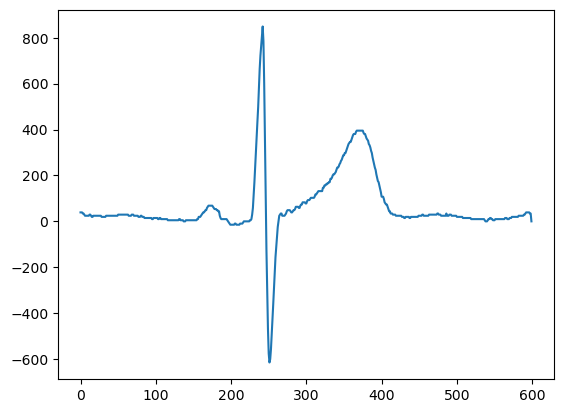

In [151]:
#Plot median waveform from dicom file
plt.plot(mbeat["V5"])

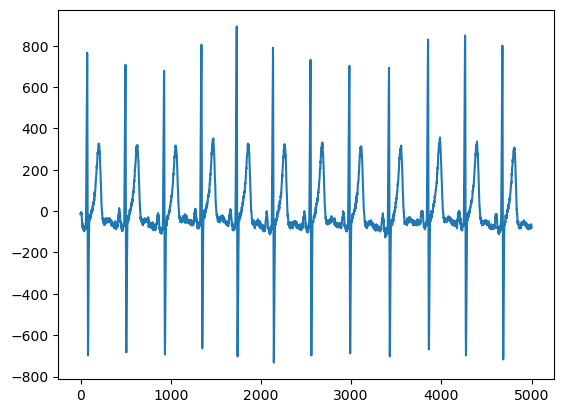

In [152]:
#Plot waveform from dicom file
plt.plot(wave["V5"])

In [144]:
# Define path
path_to_dicom = "C:/Users/Stephan.vanderZwaard/Documents/dicom/ECG-DICOM/1.3.6.1.4.1.40744.65.103877278949773242685639440347979340500.dcm"

# Read ECG from DICOM
#dicom = dcmread(path_to_dicom)
dicom = ecgreader(path_to_dicom)

In [145]:
dicom                

{'SOPinstanceUID': '1.3.6.1.4.1.40744.65.103877278949773242685639440347979340500',
 'SERIESinstanceUID': '1.3.6.1.4.1.40744.65.190628965518291668499480879207061371937',
 'STUDYinstanceUID': '1.3.6.1.4.1.40744.65.207654454939058299810711370207177297716',
 'PatientID': '99837',
 'PatientBirthDate': '',
 'PatientName': '99837',
 'PatientSex': '',
 'StudyDate': '2022-07-02',
 'StudyTime': '090725',
 'StudyDescription': 'DT4H',
 'AcquisitionDateTime': '20220702090725',
 'AcquisitionTimeZone': '+0200',
 'AccessionNumber': 'ST5EDA0794AA8E41',
 'SamplingFrequency': '500.0',
 'ChannelSensitivity': '4.88',
 'ChannelBaseline': '0.0',
 'ChannelSampleSkew': '0.0',
 'FilterLowFrequency': '0.05',
 'FilterHighFrequency': '150.0',
 'NotchFilterFrequency': '50.0',
 'Manufacturer': 'GE Healthcare',
 'ManufacturerModelName': 'Datam',
 'SoftwareVersions': ['NO SERIAL', 'MUSE_9.0.9.18167'],
 'DataExportedBy': 'AUMC^RNG',
 'Waveforms': {'I': array([14.64,  0.  , -4.88, ...,  9.76, 34.16, 24.4 ]),
  'II': arr

In [146]:
# Define path
path_to_dicom = "C:/Users/Stephan.vanderZwaard/Documents/dicom/1.3.6.1.4.1.40744.65.179071579855649261499076763286137160274.dcm"

# Read ECG from DICOM
dicom = ecgreader(path_to_dicom)
#dicom = dcmread(path_to_dicom)

# Bevestigd door
# Ventricular HR
# Atrial HR
# QRS duration
# QT interval
# QTc interval
# R-axis
# T-axis


In [147]:
dicom

{'SOPinstanceUID': '1.3.6.1.4.1.40744.65.179071579855649261499076763286137160274',
 'SERIESinstanceUID': '1.3.6.1.4.1.40744.65.140451100268227140491714488527917521387',
 'STUDYinstanceUID': '1.3.6.1.4.1.40744.65.161799212746714122422982680802615436114',
 'PatientID': '138',
 'PatientBirthDate': '',
 'PatientName': '138',
 'PatientSex': '',
 'StudyDate': '2021-10-18',
 'StudyTime': '075134',
 'StudyDescription': 'DT4H',
 'AcquisitionDateTime': '20211018075134',
 'AcquisitionTimeZone': '+0200',
 'AccessionNumber': 'ST4F7C49F1EACB35',
 'SamplingFrequency': '500.0',
 'ChannelSensitivity': '4.88',
 'ChannelBaseline': '0.0',
 'ChannelSampleSkew': '0.0',
 'FilterLowFrequency': '0.05',
 'FilterHighFrequency': '150.0',
 'NotchFilterFrequency': '50.0',
 'Manufacturer': 'GE Healthcare',
 'ManufacturerModelName': 'Datam',
 'SoftwareVersions': ['NO SERIAL', 'MUSE_9.0.9.18167'],
 'DataExportedBy': 'AUMC^RNG',
 'Waveforms': {'I': array([  -9.76,   -4.88,   -9.76, ..., -317.2 , -312.32, -307.44]),
  '

In [9]:
# Generate Table 1: median waveform
mw = pd.DataFrame(dicom['MedianWaveforms'])
mw = mw.add_prefix('lead_')
mw["id"] = mw.index
mw = pd.wide_to_long(mw, stubnames ='lead_', i="id", j="lead",suffix = '\w+').sort_index(level=0)
mw["SOPinstanceUID"] = dicom["SOPinstanceUID"]
mw["waveform"] = "median_beat"
mw = mw.reset_index()
mw = mw[["SOPinstanceUID", "waveform", "lead","id","lead_"]]
mw = mw.rename(columns = {'lead_':'voltage'})
#mw.to_csv('DICOM_ECG_WAVEFORM_MEDIANBEAT.csv', index=False)


# Generate Table 2: waveform rhythm
w = pd.DataFrame(dicom['Waveforms'])
w = w.add_prefix('lead_')
w["id"] = w.index
w = pd.wide_to_long(w, stubnames ='lead_', i="id", j="lead",suffix = '\w+').sort_index(level=0)
w["SOPinstanceUID"] = dicom["SOPinstanceUID"]
w["waveform"] = "rhythm"
w = w.reset_index()
w = w[["SOPinstanceUID", "waveform","lead", "id","lead_"]]
w = w.rename(columns = {'lead_':'voltage'})
#w.to_csv('DICOM_ECG_WAVEFORM_RHYTHM.csv', index=False)


# Generate Table 3: general info
wave = dicom.pop('Waveforms')
mbeat= dicom.pop('MedianWaveforms')
info = pd.DataFrame.from_dict(dicom, orient = 'index').transpose()
#info.to_csv('DICOM_ECG_GENERALINFO.csv', index=False)


In [6]:
dicom = dcmread(path_to_dicom)
dicom.TimezoneOffsetFromUTC

'+0100'

In [56]:
dicom[0x00120064].name
dicom[0x0040b020][0][0x00700006].value
dicom[0x004008ea][0][0x00700006].value

'Atriumfibrilleren'

## TEST ECG FROM SET MARYAM (VUMC LOCATION)

In [108]:
# Define path
path_to_dicom = "C:/Users/Stephan.vanderZwaard/Documents/dicom/TEST_ECGs/"

# Obtain all DICOM files
ECG_files = list() 
for path, subdirs, files in os.walk(path_to_dicom):
    for filename in files:
        ECG_files.append(path+'/'+filename)

In [109]:
dicom = ecgreader(ECG_files[10])
#dicom = dcmread(ECG_files[11])

In [110]:
dicom

{'SOPinstanceUID': '1.3.6.1.4.1.40744.65.122185835862583849475409957050689237070',
 'SERIESinstanceUID': '1.3.6.1.4.1.40744.65.326141391931400535648610028774861581219',
 'STUDYinstanceUID': '1.3.6.1.4.1.40744.65.224692259690641284320907474223306100191',
 'PatientID': '25320',
 'PatientBirthDate': '',
 'PatientName': '25320',
 'PatientSex': '',
 'StudyDate': '2019-08-27',
 'StudyTime': '054450',
 'StudyDescription': 'DT4H',
 'AcquisitionDateTime': '20190827054450',
 'AcquisitionTimeZone': '+0200',
 'AccessionNumber': 'ST20190827',
 'SamplingFrequency': '500.0',
 'ChannelSensitivity': '5.0',
 'ChannelBaseline': '0.0',
 'ChannelSampleSkew': '0.0',
 'FilterLowFrequency': '0.05',
 'FilterHighFrequency': '150.0',
 'NotchFilterFrequency': '',
 'Manufacturer': 'Philips Medical Products',
 'ManufacturerModelName': 'IntelliVue',
 'SoftwareVersions': '1.04.02',
 'DataExportedBy': 'AUMC^EVA',
 'Waveforms': {'I (Einthoven)': array([-40., -25., -40., ..., -25., -10., -25.]),
  'II': array([ 115.,  1

In [111]:
dicom = dcmread(ECG_files[17])
dicom.dir()
#print(dicom[0x00020002])

['AccessionNumber',
 'AcquisitionDate',
 'AcquisitionTime',
 'BurnedInAnnotation',
 'ConceptNameCodeSequence',
 'ContentDate',
 'ContentLabel',
 'ContentTime',
 'CurveDate',
 'DocumentTitle',
 'EncapsulatedDocument',
 'FillerOrderNumberImagingServiceRequest',
 'InstanceCreationDate',
 'InstanceCreationTime',
 'InstanceNumber',
 'IssuerOfPatientID',
 'IssuerOfPatientIDQualifiersSequence',
 'MIMETypeOfEncapsulatedDocument',
 'Manufacturer',
 'ManufacturerModelName',
 'Modality',
 'PatientBirthDate',
 'PatientID',
 'PatientName',
 'PatientSex',
 'RequestedProcedureCodeSequence',
 'RequestedProcedurePriority',
 'SOPClassUID',
 'SOPInstanceUID',
 'SeriesDate',
 'SeriesDescription',
 'SeriesInstanceUID',
 'SeriesNumber',
 'SeriesTime',
 'SoftwareVersions',
 'SpecificCharacterSet',
 'StudyDate',
 'StudyDescription',
 'StudyInstanceUID',
 'StudyStatusID',
 'StudyTime',
 'TimezoneOffsetFromUTC']

In [112]:
len(ECG_files)

24

In [128]:
# Read ECG from DICOM


# Preallocate dataframes
general_info   = pd.DataFrame()
median_waves   = pd.DataFrame()
original_waves = pd.DataFrame()
error_dicom    = pd.DataFrame()

# Set-up progressbar
i_start = 0
i_end   = 23
pbar    = progressbar.ProgressBar(maxval = len(ECG_files[i_start:i_end])-1).start()

for i in range(i_start,i_end) : 
    
    try:
        dicom = ecgreader(ECG_files[i], verbose=False)

        # Generate Table 1: median waveform
        mw = pd.DataFrame(dicom['MedianWaveforms'])
        mw = mw.add_prefix('lead_')
        mw["id"] = mw.index
        mw = pd.wide_to_long(mw, stubnames ='lead_', i="id", j="lead",suffix = '\w+').sort_index(level=0)
        mw["SOPinstanceUID"] = dicom["SOPinstanceUID"]
        mw["waveform"] = "median_beat"
        mw = mw.reset_index()
        mw = mw[["SOPinstanceUID", "waveform", "lead","id","lead_"]]
        mw = mw.rename(columns = {'lead_':'voltage'})


        # Generate Table 2: waveform rhythm
        w = pd.DataFrame(dicom['Waveforms'])
        w = w.add_prefix('lead_')
        w["id"] = w.index
        w = pd.wide_to_long(w, stubnames ='lead_', i="id", j="lead",suffix = '\w+').sort_index(level=0)
        w["SOPinstanceUID"] = dicom["SOPinstanceUID"]
        w["waveform"] = "rhythm"
        w = w.reset_index()
        w = w[["SOPinstanceUID", "waveform","lead", "id","lead_"]]
        w = w.rename(columns = {'lead_':'voltage'})


        # Generate Table 3: general info
        wave = dicom.pop('Waveforms')
        mbeat= dicom.pop('MedianWaveforms')
        info = pd.DataFrame.from_dict(dicom, orient = 'index').transpose()


        # Combine data with other records
        general_info    = pd.concat([general_info,info], axis=0)
        median_waves    = pd.concat([median_waves,mw], axis=0)
        original_waves  = pd.concat([original_waves,w], axis=0)
    
    except:
        dicom['file_no'] = i
        dicom['filename'] = ECG_files[i].replace('C:/Users/Stephan.vanderZwaard/Documents/dicom/','')
        error_dicom     = pd.concat([error_dicom,dicom], axis=0)
        
    # Update progressbar
    pbar.update(i-i_start)


In [83]:
median_waves.loc[median_waves['SOPinstanceUID'] == '1.3.6.1.4.1.40744.65.214950033209762893283513913898962270513']

,SOPinstanceUID,waveform,lead,id,voltage
0,1.3.6.1.4.1.40744.65.2149500332097628932835139...,median_beat,I,0,-2.425319e-14
1,1.3.6.1.4.1.40744.65.2149500332097628932835139...,median_beat,II,0,-1.212660e-14
2,1.3.6.1.4.1.40744.65.2149500332097628932835139...,median_beat,III,0,0.000000e+00
3,1.3.6.1.4.1.40744.65.2149500332097628932835139...,median_beat,V1,0,-1.212660e-14
4,1.3.6.1.4.1.40744.65.2149500332097628932835139...,median_beat,V2,0,1.212660e-14
...,...,...,...,...,...
7195,1.3.6.1.4.1.40744.65.2149500332097628932835139...,median_beat,V5,599,5.616951e+01
7196,1.3.6.1.4.1.40744.65.2149500332097628932835139...,median_beat,V6,599,3.207172e+01
7197,1.3.6.1.4.1.40744.65.2149500332097628932835139...,median_beat,aVF,599,2.795612e+01
7198,1.3.6.1.4.1.40744.65.2149500332097628932835139...,median_beat,aVL,599,1.635026e+01


In [129]:
error_dicom

,filetype,error,file_no,filename
0,Encapsulated PDF Storage,No ECG waveform present,17,TEST_ECGs/VUMC-2015/1.3.6.1.4.1.40744.65.25250...
0,Encapsulated PDF Storage,No ECG waveform present,18,TEST_ECGs/VUMC-2015/1.3.6.1.4.1.40744.65.31370...


In [131]:
error_dicom.to_csv('DICOM_error.csv', index=False)
general_info.to_csv('DICOM_GENERAL_INFO.csv', index=False)


In [48]:
ECG_files

['C:/Users/Stephan.vanderZwaard/Documents/dicom/TEST_ECGs/1999/1.3.6.1.4.1.40744.65.214950033209762893283513913898962270513.dcm',
 'C:/Users/Stephan.vanderZwaard/Documents/dicom/TEST_ECGs/1999/1.3.6.1.4.1.40744.65.296664842565694373641813110520948861036.dcm',
 'C:/Users/Stephan.vanderZwaard/Documents/dicom/TEST_ECGs/1999/1.3.6.1.4.1.40744.65.53803799701603430799992237477638387629.dcm',
 'C:/Users/Stephan.vanderZwaard/Documents/dicom/TEST_ECGs/1999/1.3.6.1.4.1.40744.65.95776518451979112237224353381048862240.dcm',
 'C:/Users/Stephan.vanderZwaard/Documents/dicom/TEST_ECGs/AMC-2005-2012/1.3.6.1.4.1.40744.65.112086594598181877648256030701249944705.dcm',
 'C:/Users/Stephan.vanderZwaard/Documents/dicom/TEST_ECGs/AMC-2005-2012/1.3.6.1.4.1.40744.65.253813409696510369098432251424919566276.dcm',
 'C:/Users/Stephan.vanderZwaard/Documents/dicom/TEST_ECGs/AMC-2005-2012/1.3.6.1.4.1.40744.65.317085662038435904670797338355262988894.dcm',
 'C:/Users/Stephan.vanderZwaard/Documents/dicom/TEST_ECGs/AMC-200

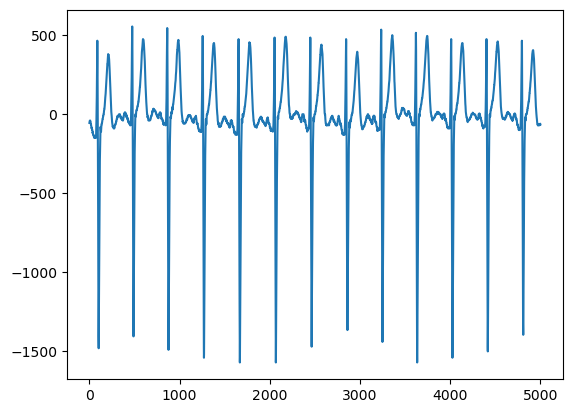

In [54]:
plt.plot(dicom["Waveforms"]["V2"])

In [42]:
dicom

{'SOPinstanceUID': '1.3.6.1.4.1.40744.65.305228147552084644291303736218344355210',
 'SERIESinstanceUID': '1.3.6.1.4.1.40744.65.313581043198665037787448051457439774958',
 'STUDYinstanceUID': '1.3.6.1.4.1.40744.65.110564859296102927602243829510532992235',
 'PatientID': '24810',
 'PatientBirthDate': '',
 'PatientName': '24810',
 'PatientSex': '',
 'StudyDate': '2013-02-20',
 'StudyTime': '134800',
 'StudyDescription': 'DT4H',
 'AcquisitionDateTime': '20130220134800',
 'AcquisitionTimeZone': '+0100',
 'AccessionNumber': 'ST20130220',
 'SamplingFrequency': '500.0',
 'ChannelSensitivity': '5.0',
 'ChannelBaseline': '0.0',
 'ChannelSampleSkew': '0.0',
 'FilterLowFrequency': '0.15',
 'FilterHighFrequency': '150.0',
 'NotchFilterFrequency': '50.0',
 'Manufacturer': 'GE',
 'ManufacturerModelName': 'MAC55',
 'SoftwareVersions': '',
 'DataExportedBy': 'AUMC^EVA'}

In [43]:
i

22